In [1]:
# pip install reportlab
# pip install scipy

In [2]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import pprint as pp
import os
import datetime
import scipy.stats as st
from matplotlib.backends.backend_pdf import PdfPages
import io
from PIL import Image as PILImage
from reportlab.platypus import Table, TableStyle, Paragraph, Spacer, Image, ListFlowable, ListItem, SimpleDocTemplate
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import datetime

current_path = os.getcwd()

stimulus_path = os.path.join(current_path, r"run_20250313_1439\run_data.json")
gaze_path = os.path.join(current_path, r"run_20250313_1439\eye_tracking_data.json")
print(stimulus_path)
print(gaze_path)

C:\Users\Caleb\Documents\nik-INP\visual-field-mapping-testing-and-correction\IntegratedVFTnR\Assets\Saved Data\run_20250313_1439\run_data.json
C:\Users\Caleb\Documents\nik-INP\visual-field-mapping-testing-and-correction\IntegratedVFTnR\Assets\Saved Data\run_20250313_1439\eye_tracking_data.json


In [3]:
def get_stimulus_data(path):
    
    file_path = path

    with open(file_path, "r") as file:
        data = json.load(file)

    file.close()

    # Extract coordinates and detection info
    coords = np.array([(data["coords"][i]['x'],data["coords"][i]['y']) for i in range(len(data["coords"]))])
    detected = np.array(data["detected"])
    stimulusTime = np.array(data["stimulusTime"])

    reactionTime = np.array(data["reactionTime"])
    filter_arr = reactionTime != -1

    misc = {
        "testDuration" : data["testDuration"],
        "averageReactionTime" : np.mean(reactionTime[filter_arr]),
        "numstimulus": data["numberOfPoints"],
        "flashDuration": data["flashDuration"],
        "centerSize" : data["centerSize"],
    }

    min_x = np.min(coords[:,0])
    max_x = np.max(coords[:,0])
    min_y = np.min(coords[:,1])
    max_y = np.max(coords[:,1])

    lim_range = [(min_x, max_x), (min_y, max_y)]

    # create dictionary to store coordinates and detection counts
    coord_dict={}
    for coord in coords:
        coord_dict[f"{coord[0]},{coord[1]}"] = 0

    # add the detection count 
    for i, coord in enumerate(coords):
        if detected[i]:
            coord_dict[f"{coord[0]},{coord[1]}"]+=1

    # extract back out the coords and detection counts as np arrays
    coords_set=[]
    detectedcount=[]
    for coord, count in coord_dict.items():
        x,y = coord.split(",")
        coords_set.append([float(x), float(y)])
        detectedcount.append(count)

    coords_set = np.array(coords_set)
    detectedcount = np.array(detectedcount)
    cmap = ["w" if count==3 else "lightgrey" if count == 2 else "grey" if count == 1 else "black" for count in detectedcount]
    
    # Combine coords and detected into one array to be returned to calculate false positives
    coords = np.concatenate((coords, np.array([data["detected"]]).T), axis=1)
    
    return coords_set, detectedcount, cmap, lim_range, stimulusTime, misc, coords

In [4]:
def get_gaze_data(path):
    gaze_path = path

    with open(gaze_path, "r") as file:
        gaze_data = json.load(file)

    file.close()

    # Extract gaze info
    gaze_coords = np.array([(gaze_data["coords"][i]['x'],gaze_data["coords"][i]['y']) for i in range(len(gaze_data["coords"]))])
    gaze_time = np.array(gaze_data["timeywimey"])
    lookingAtStim = np.array(gaze_data["lookingAtStim"])
    
    return gaze_coords, gaze_time, lookingAtStim


In [5]:
def plot_gaze_hist(x, y, bins=250, lim_range=[(-5,5),(-5,5)]):
    
    min_x=lim_range[0][0]
    max_x=lim_range[0][1]
    min_y=lim_range[1][0]
    max_y=lim_range[1][1]
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=lim_range)
    fig = plt.figure(figsize=(6, 6))
    # imshow expects row-major data, so need to transpose the heatmap
    # extent sets the [xmin, xmax, ymin, ymax] range for the axes
    plt.imshow(
        heatmap.T, 
        origin='lower', 
        cmap='hot_r', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    )
    plt.xticks(np.arange(min_x, max_x+1, 1))
    plt.yticks(np.arange(min_y, max_y+1, 1))
    plt.xlim(min_x-1, max_x+1)
    plt.ylim(min_y-1, max_y+1)
    
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.title('Gaze Heatmap')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
#     plt.show()
    
    return fig

In [6]:
def plot_gaze_contours(x, y, bins=50, lim_range=[(-5,5),(-5,5)]):
    """
    x, y: 1D arrays of your 2D data
    bins: number of points in the meshgrid for contour resolution
    lim_range: limits of x and y axis
    """
    
    min_x=lim_range[0][0]
    max_x=lim_range[0][1]
    min_y=lim_range[1][0]
    max_y=lim_range[1][1]

    # Create a meshgrid that covers the range of your data
    xmin, xmax = min_x-1, max_x
    ymin, ymax = min_y-1, max_y
    X, Y = np.mgrid[xmin:xmax:complex(bins), ymin:ymax:complex(bins)]
    positions = np.vstack([X.ravel(), Y.ravel()])  # shape (2, bins^2)

    # Fit a 2D Gaussian KDE to data
    values = np.vstack([x, y])  # shape (2, N)
    kernel = st.gaussian_kde(values)

    # Evaluate the KDE on the grid
    Z = np.reshape(kernel(positions), X.shape)

    # Plot the filled contours
    fig = plt.figure(figsize=(6,6))
    plt.contourf(X, Y, Z, cmap='hot_r', levels=1000)
    
    plt.xticks(np.arange(min_x, max_x+1, 1))
    plt.yticks(np.arange(min_y, max_y+1, 1))
    plt.xlim(min_x-1, max_x+1)
    plt.ylim(min_y-1, max_y+1)
    plt.grid(True, linestyle='--', alpha=0.2)
    
    plt.title('Gaze Heatmap')
    plt.xlabel('X coordinates')
    plt.ylabel('Y coordinates')
#     plt.show()
    
    return fig

In [7]:
def plot_greyscale_patch(x, y, lim_range=[(-5,5),(-5,5)]):
    
    min_x=lim_range[0][0]
    max_x=lim_range[0][1]
    min_y=lim_range[1][0]
    max_y=lim_range[1][1]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, marker="s", s=700 ,c=cmap, zorder=3)
    ax.scatter(0,0,marker="s",c="white", s=750, zorder=3)

    # taken from alfie
    # for the center spines
    ax.axhline(y=0, color='blue', zorder=4)
    ax.axvline(x=0, color='blue', zorder=4)
    for y in np.arange(min_y, max_y):
        ax.plot([-0.2, 0.2], [y, y], color='blue', zorder=4)
    for x in np.arange(min_x, max_x):
        ax.plot([x, x], [-0.2, 0.2], color='blue', zorder=4)

    plt.gca().set_facecolor((0.90, 0.90, 0.90))
    plt.grid(True, linestyle='--', zorder=1)

    ax.set_xticks(np.arange(min_x, max_x+1, 1))
    ax.set_yticks(np.arange(min_y, max_y+1, 1))
    ax.set_xlim(min_x-1, max_x+1)
    ax.set_ylim(min_y-1, max_y+1)

    plt.title('Grayscale Map')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

#     plt.show()
    
    return fig

In [8]:
def plot_cell_dotpattern(ax, cell_x, cell_y, detect_count):
    """
    cell_i, cell_j are in [0..rows-1], detection_count in [0..3].
    We'll convert these to x,y in [-5..+5] range.
    Then place sub-dots in that cell.
    The more missed, the denser the dots in the cell.
    3 -> [2,2] dots, 2 -> [5,5] dots, 1 -> [8,8] dots, 0 -> [12,12] dots 
    """
    
    if detect_count==0:
        dot_density = 1/12
    elif detect_count==1:
        dot_density = 1/8
    elif detect_count == 2:
        dot_density = 1/5
    else:
        dot_density = 1/2
        
#     x_array = np.arange(cell_x-0.5, cell_x+0.5+dot_density, dot_density) 
#     y_array = np.arange(cell_y-0.5, cell_y+0.5+dot_density, dot_density) 
    x_array = np.arange(cell_x-0.5+dot_density/2, cell_x+0.5+dot_density/2, dot_density) 
    y_array = np.arange(cell_y-0.5+dot_density/2, cell_y+0.5+dot_density/2, dot_density) 
#     print(x_array,y_array)
    X, Y = np.meshgrid(x_array, y_array)
    result = np.column_stack((X.ravel(), Y.ravel()))
    ax.scatter(result[:,0],result[:,1], s=4, c="black", zorder=3)

In [9]:
def plot_greyscale_dots(coords, detectedcount, lim_range=[(-5,5),(-5,5)]):
    
    min_x=lim_range[0][0]
    max_x=lim_range[0][1]
    min_y=lim_range[1][0]
    max_y=lim_range[1][1]
    
    fig, ax = plt.subplots(figsize=(6, 6))

    for i, coord in enumerate(coords):
        plot_cell_dotpattern(ax,coord[0],coord[1],detectedcount[i])

    ax.axhline(y=0, color='blue', zorder=4)
    ax.axvline(x=0, color='blue', zorder=4)
    for y in np.arange(min_y, max_y):
        ax.plot([-0.2, 0.2], [y, y], color='blue', zorder=4)
    for x in np.arange(min_x, max_x):
        ax.plot([x, x], [-0.2, 0.2], color='blue', zorder=4)

    plt.grid(True, linestyle='--', zorder=1, alpha=0.3)

    ax.set_xticks(np.arange(min_x, max_x+1, 1))
    ax.set_yticks(np.arange(min_y, max_y+1, 1))
    ax.set_xlim(min_x-1, max_x+1)
    ax.set_ylim(min_y-1, max_y+1)

    plt.title('Grayscale Map')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    timenow=datetime.datetime.now().strftime("%d-%m-%y_%H-%M-%S")
    savepath = current_path + f"/greyscale_{timenow}.png"

    # while os.path.exists(savepath):
    #     savecount+=1
    #     savepath = current_path + f"VFTestingAndRemapping/Assets/Saved Data/greyscale_{savecount}.png"

#     print(savepath)
    # plt.savefig(savepath)
#     plt.show()
    
    return fig

In [10]:
def plot_false_positive(coords, stimulus_time, flashDuration, gaze_time, lookingAtStim, lim_range=[(-5,5),(-5,5)]):
    false_pos_coords = []
    false_neg_coords = []
    for i,coord in enumerate(coords):
        time_dot_appears = stimulus_time[i]
        time_dot_disappears = stimulus_time[i] + flashDuration
        any_not_focus = False
        for j, time in enumerate(gaze_time):
            # check time during the dot appears and disappears
            if (time >= time_dot_appears and time <= time_dot_disappears):
                if not lookingAtStim[j]:
                    any_not_focus = True
                    break

        #if user "detected" but broke focus on center during the time the stimulus appear
        if coord[2] == 1 and any_not_focus:
            # append coord to false positive list
            false_pos_coords.append([coord[0], coord[1]])
        # if user "not detected" but was focusing on center during the time the stimulus appear
        elif coord[2] == 0 and not any_not_focus:
            # append coord to false negative list
            false_neg_coords.append([coord[0], coord[1]])

    false_pos_coords = np.array(false_pos_coords)
    false_neg_coords = np.array(false_neg_coords)
    false_positive_rate = len(false_pos_coords)/len(coords)*100
    false_negative_rate = len(false_neg_coords)/len(coords)*100

    min_x=lim_range[0][0]
    max_x=lim_range[0][1]
    min_y=lim_range[1][0]
    max_y=lim_range[1][1]

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(false_pos_coords[:,0], false_pos_coords[:,1],marker="s", s=700, c = "grey", zorder=1)
    
    ax.axhline(y=0, color='blue', zorder=4)
    ax.axvline(x=0, color='blue', zorder=4)
    for y in np.arange(min_y, max_y):
        ax.plot([-0.2, 0.2], [y, y], color='blue', zorder=4)
    for x in np.arange(min_x, max_x):
        ax.plot([x, x], [-0.2, 0.2], color='blue', zorder=4)


    ax.set_xticks(np.arange(min_x, max_x+1, 1))
    ax.set_yticks(np.arange(min_y, max_y+1, 1))
    ax.set_xlim(min_x-1, max_x+1)
    ax.set_ylim(min_y-1, max_y+1)
    plt.grid(True, linestyle='--', alpha=0.2)

    plt.title('False Positives')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    return fig, false_positive_rate, false_negative_rate


In [11]:
coords_set, detectedcount, cmap, lim_range, stimulus_time, misc, coords= get_stimulus_data(stimulus_path)
gaze_coords, gaze_time, lookingAtStim = get_gaze_data(gaze_path)

X, Y = coords_set[:,0], coords_set[:,1]
gaze_X, gaze_Y = gaze_coords[:,0], gaze_coords[:,1]

gaze_center = []
# center_r = misc["centerSize"]/2
center_r = 1
for gx, gy in gaze_coords:
    if ((gx**2 + gy**2) <= center_r**2):
        gaze_center.append([gx,gy])
        
gaze_percentage = len(gaze_center)/(len(gaze_coords))*100

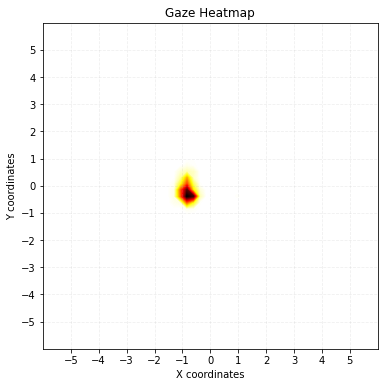

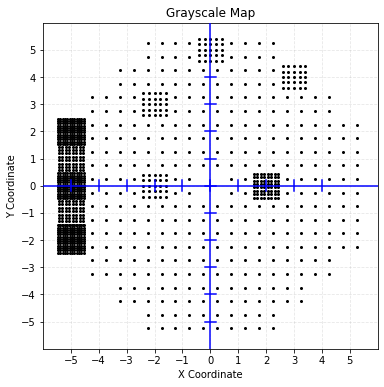

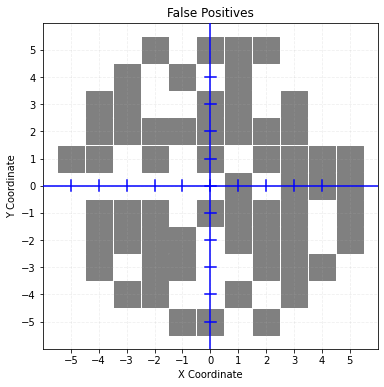

In [12]:
# gaze_h_plot = plot_gaze_hist(gaze_X, gaze_Y, lim_range=lim_range)
gaze_c_plot = plot_gaze_contours(gaze_X, gaze_Y, lim_range=lim_range)
# greyscale_p_plot = plot_greyscale_patch(X, Y, lim_range=lim_range)
greyscale_d_plot = plot_greyscale_dots(coords_set, detectedcount, lim_range=lim_range)
false_pos_plot, false_positive_rate, false_negative_rate = plot_false_positive(coords, stimulus_time, misc["flashDuration"], gaze_time, lookingAtStim, lim_range)

In [13]:
def fig_to_img(fig, width=300, height=300):
    
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
#     pil_img = PILImage.open(buf)
    return Image(buf, width=width, height=height)

In [14]:
name = "REDACTED"
age = "REDACTED"
date = datetime.datetime.now().strftime("%Y-%m-%d")
time = datetime.datetime.now().strftime("%H:%M:%S")
date_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
duration = misc["testDuration"]
flashDuration = misc["flashDuration"]*1000
numstimulus = misc["numstimulus"]
falsepos = false_positive_rate
reactiontime = misc["averageReactionTime"]*1000
fixation = gaze_percentage

In [15]:
styles = getSampleStyleSheet()

styles['Heading1'].fontSize = 20
styles['Heading2'].fontSize = 14
styles['Normal'].fontSize = 11
styles['Heading3'].fontSize = 11
styles['Heading3'].textColor = "white"

# 1) Example top row: Title vs. Date
left_top = [
    Paragraph("<b>Visual Test Report</b>", styles['Heading1']),
    Paragraph(f"Name: {name}", styles['Normal']),
    Paragraph(f"Age: {age}", styles['Normal']),
#     Paragraph(f"Time: {time}", styles['Normal']),
    Paragraph(f"Test Duration: {duration:.2f}s", styles['Normal'])
]
right_top = [
    Paragraph(f"{date_time}", styles['Normal'])
]

# 2) Stim info vs. Fixation info
left_middle = [
#     Paragraph("<b>Stimulus Info</b>", styles['Heading2']),
    Paragraph("Fixation Monitor: Gaze", styles['Normal']),
    Paragraph("Fixation Target: Central", styles['Normal']),
    Paragraph(f"Flash Duration: {flashDuration:.2f}ms", styles['Normal']),
    Paragraph(f"Number of stimuli: {numstimulus}", styles['Normal']),
]

right_middle = [
#     Paragraph("<b>Fixation Info</b>", styles['Heading2']),
    Paragraph("Stimulus: White 0.05", styles['Normal']),
    Paragraph("Background: RGB(32,32,32)", styles['Normal']),
    Paragraph("Canvas: Plane", styles['Normal']),
    Paragraph("Strategy: Repeated Fixed-Intensity", styles['Normal']),
]

# 3) The center plot on left, metrics on right
# We'll store them in variables once they are created
greyscale_d_img = fig_to_img(greyscale_d_plot, width=300, height=300)
gaze_c_img = fig_to_img(gaze_c_plot, width=250, height=250)
false_pos_img = fig_to_img(false_pos_plot, width=250, height=250)

metrics_list = [
    f"False Positive: {falsepos*numstimulus/100:.0f}/{numstimulus}",
    f"False Negative: {false_negative_rate*numstimulus/100:.0f}/{numstimulus}",
    f"False Positive Error Rate: {falsepos:.2f}%",
    f"False Negative Error Rate: {false_negative_rate:.2f}%",
    f"Average Reaction Time: {reactiontime:.2f}ms",
    f"Center Fixation Percentage: {fixation:.2f}%"
]

metrics_flow = []
metrics_flow.append(Paragraph("", styles['Heading2']))
metrics_flow.append(Paragraph("<b>Test Metrics</b>", styles['Heading2']))
for item in metrics_list:
    metrics_flow.append(Paragraph(item, styles['Normal']))

legend_img = Image(os.path.join(r"C:\Users\Caleb\Documents\nik-INP\visual-field-mapping-testing-and-correction\IntegratedVFTnR\Assets\Python Script","legend.png"), width=50, height=110)
# metrics_flow.append(Spacer(1, 12))
metrics_flow.append(legend_img)

# 4) Convert these sub-lists into Flowables for each column
def vstack(flow_list):
    """Helper: combine multiple paragraphs in a single column with spacing."""
    combined = []
    for f in flow_list:
        combined.append(f)
        combined.append(Spacer(1, 5))
    return combined

empty_col = [
    Paragraph("easter egg :)", styles['Heading3'])
]

left_top_col = vstack(left_top)
right_top_col = vstack(right_top)



left_middle_col = vstack(left_middle)
right_middle_col = vstack(right_middle)

left_plot_col = [greyscale_d_img]  # single item
right_metrics_col = vstack(metrics_flow)

gaze_col = [gaze_c_img]
error_col = [false_pos_img]

# 5) Now build a single table with multiple rows, each row has two cells: (left, right)
table_data = [
    [left_top_col, right_top_col],
    [empty_col, empty_col],
    [left_middle_col, right_middle_col],
    [left_plot_col, right_metrics_col],
]

table_data_2 = [
    [gaze_col, error_col]
]

table_style = TableStyle([
    ('VALIGN', (0,0), (-1,-1), 'TOP'),  # top-align all cells
    ('LEFTPADDING', (0,0), (-1,-1), 6),
    ('RIGHTPADDING', (0,0), (-1,-1), 6),
    ('TOPPADDING', (0,0), (-1,-1), 1),
    ('BOTTOMPADDING', (0,0), (-1,-1), 1),
    # Optionally add lines:
    # ('BOX', (0,0), (-1,-1), 0.5, colors.grey),
    # ('INNERGRID', (0,0), (-1,-1), 0.25, colors.grey),
])

# E.g. widths: left column 300 pts, right column 200 pts
colWidths = [300, 200]
colWidths_2 = [250, 250]

main_table = Table(table_data, colWidths=colWidths, style=table_style)
sub_table = Table(table_data_2, colWidths=colWidths_2, style=table_style)

report_date = datetime.datetime.now().strftime("%Y%m%d_%H%M")
save_path = os.path.join(current_path, f"Visual Field Report_{report_date}.pdf")

doc = SimpleDocTemplate(save_path, topMargin=36, bottomMargin=36)
story = []

# Suppose we built 'main_table' from above snippet
story.append(main_table)
story.append(sub_table)

doc.build(story)

print("done")

done


cant be too bright, pupil dilation may affect the test

change the test such that itll retest area that were not detected either by increasing brightness or just no change

Repeating each point 3 times (or more) helps reduce false positives/negatives due to random guessing or blinking.

The user (and test administrator) sees an intuitive map of “seen vs. not seen,” rather than needing to interpret decibel values.
No True Threshold

A single brightness can’t tell you how sensitive the user is at each location—only whether they do or don’t detect that specific brightness.
In real perimetry, threshold data (in dB) is more informative for diagnosing mild vs. severe defects.
Choice of Stimulus Intensity

If the brightness is too high, everyone sees it at all points → not very informative.

If it’s too low, everyone fails at all points → also not useful.

You may need to pilot-test or calibrate to find a middle ground that reveals interesting differences among users.

No Standard Clinical Correlation

The standard Humphrey or Octopus perimeters rely on gradually adjusting brightness to measure threshold. Your single-level approach is a non-standard screening method rather than a direct equivalent to a clinical HVF test.

calculate the angle (use the distance from XR rig to the distance of the screen) aim for 60degrees total (24-30) and each dot is spaced around 6 deg from each other

TESTTTTT USER EVALLLL
no feeback but still track eye gaze, and then compare false postive to one with feedback :))